In [57]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
from resemblyzer import VoiceEncoder, preprocess_wav

In [2]:
real_audio = "real_test.wav"
fake_audio = "deepfake_test.wav"

In [41]:
def get_voice_embedding(file_path):
    """
    Carica e preprocessa il file audio usando Resemblyzer,
    estrae l'embedding vocale e restituisce:
    - embedding: vettore rappresentativo della voce
    - wav: segnale audio preprocessato (waveform)
    
    Resemblyzer opera su audio a 16kHz, quindi il preprocessing lo adatta.
    """
    wav = preprocess_wav(file_path) #load audio file, resemble, trimming to remove silences
    encoder = VoiceEncoder()
    embedding = encoder.embed_utterance(wav) 
    return embedding, wav, encoder

- *VoiceEncoder().embed_utterance(wav):* model generates a symbolic numeric representation (embedding) which captures the timber and style characteristics, making the comparison robustly even the verbal content differs.

In [42]:
#Estrai gli embedding vocali per ciascun audio
emb1, wav1, encoder = get_voice_embedding(real_audio)
emb2, wav2, _ = get_voice_embedding(fake_audio)

Loaded the voice encoder model on cpu in 0.01 seconds.
Loaded the voice encoder model on cpu in 0.01 seconds.


# Cosine Similarity
The embedding comparison is made with cosine similarity: it measures how much two vectors points in the same director. Values differs from -1 and 1
- **1.0:** perfect similarity
- **0.0:** completely different
- **-1.0:** opposite


In [43]:
def compute_cosine_similarity(emb1, emb2):
    """
    Calcola la similarità coseno tra due embedding vocali.
    """
    return np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))

In [44]:
# Calcola la similarità coseno tra i due embedding
similarity = compute_cosine_similarity(emb1, emb2)
print(f"Cosine Similarity between real and deepfake audio: {similarity:.2f}")

Cosine Similarity between real and deepfake audio: 0.94


# MFCCS (Mel Frequency Cepstral Coefficients)



In [47]:
def plot_mfccs_normalized(wav1, wav2, sr=16000, hop_length=512):
    """
    Estrae e visualizza i MFCC di due audio, normalizzando l'asse del tempo in percentuale.
    Questo permette di confrontare visivamente la struttura degli MFCC
    indipendentemente dalla durata assoluta degli audio.
    """
    # Estrazione degli MFCC con un hop_length definito
    mfcc1 = librosa.feature.mfcc(y=wav1, sr=sr, n_mfcc=13, hop_length=hop_length)
    mfcc2 = librosa.feature.mfcc(y=wav2, sr=sr, n_mfcc=13, hop_length=hop_length)
    
    # Creazione di un asse tempo normalizzato (0-100%)
    times1_norm = np.linspace(0, 100, mfcc1.shape[1])
    times2_norm = np.linspace(0, 100, mfcc2.shape[1])
    
    plt.figure(figsize=(12, 8))
    
    # Plot per l'audio reale
    plt.subplot(2, 1, 1)
    plt.imshow(mfcc1, aspect='auto', origin='lower', 
               extent=[times1_norm[0], times1_norm[-1], 0, mfcc1.shape[0]])
    plt.title("MFCC - Real Audio (Normalized Time)")
    plt.xlabel("Duration (%)")
    plt.ylabel("MFCC Coefficients")
    plt.colorbar(format="%+2.0f dB")
    
    # Plot per l'audio deepfake
    plt.subplot(2, 1, 2)
    plt.imshow(mfcc2, aspect='auto', origin='lower', 
               extent=[times2_norm[0], times2_norm[-1], 0, mfcc2.shape[0]])
    plt.title("MFCC - Deepfake Audio (Normalized Time)")
    plt.xlabel("Duration (%)")
    plt.ylabel("MFCC Coefficients")
    plt.colorbar(format="%+2.0f dB")
    
    plt.tight_layout()
    plt.show()

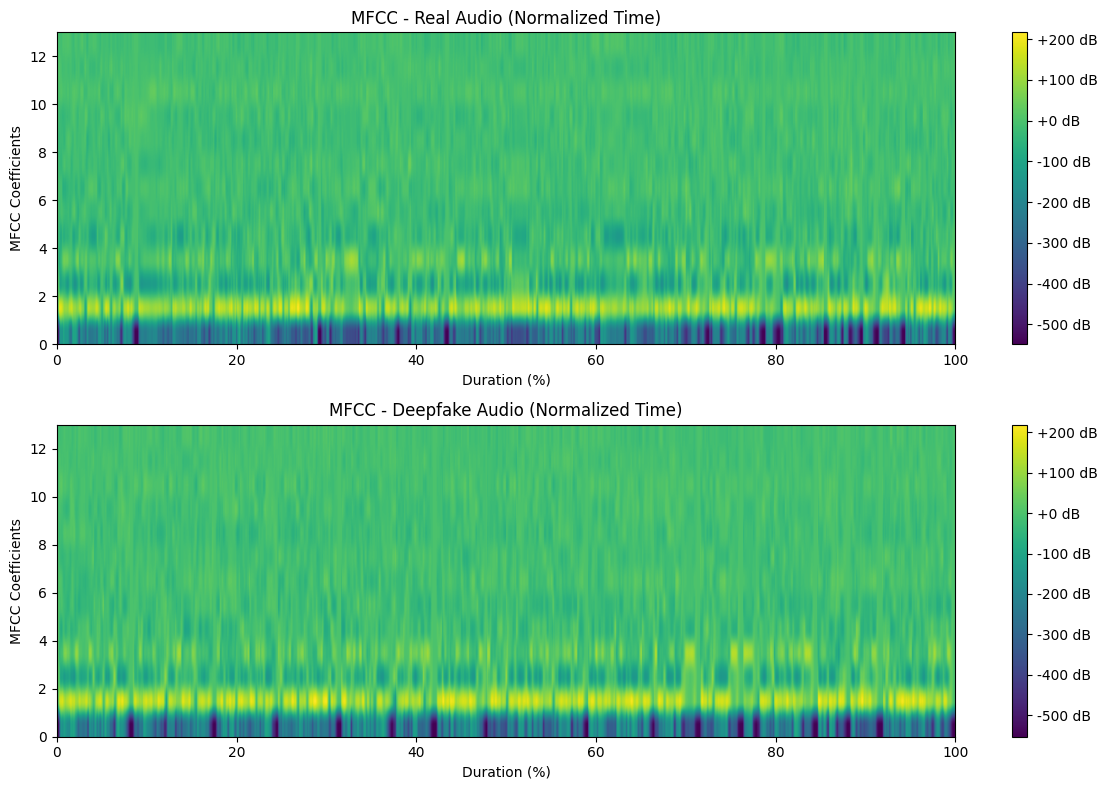

In [48]:
plot_mfccs_normalized(wav1, wav2, sr=16000)

# Pitch Analysis (F0)
- Extraction of the fundamental frequency to trace the pitch trajectory over time, normalized as a percentage (0–100%) to be able to compare audio of different durations.
- Visualization of the pitch distribution via histogram, after removing any NaN values.

In [49]:
def compute_pitch(y, sr):
    """
    Estrae la frequenza fondamentale (pitch) usando il metodo pyin.
    """
    f0, _, _ = librosa.pyin(y, 
                            fmin=librosa.note_to_hz('C2'),
                            fmax=librosa.note_to_hz('C7'))
    return f0

def plot_pitch_comparison(wav1, wav2, sr, hop_length=512):
    """
    Visualizza le traiettorie del pitch (F0) per entrambi gli audio, normalizzando l'asse temporale
    e impostando la stessa scala sull'asse y per un confronto equo.
    """
    f0_1 = compute_pitch(wav1, sr)
    f0_2 = compute_pitch(wav2, sr)
    
    # Rimuove i valori NaN per calcolare i limiti globali
    f0_1_valid = f0_1[~np.isnan(f0_1)]
    f0_2_valid = f0_2[~np.isnan(f0_2)]
    global_min = min(f0_1_valid.min(), f0_2_valid.min())
    global_max = max(f0_1_valid.max(), f0_2_valid.max())
    
    # Crea assi temporali normalizzati (0-100%)
    times1 = np.linspace(0, 100, len(f0_1))
    times2 = np.linspace(0, 100, len(f0_2))
    
    plt.figure(figsize=(12, 6))
    
    # Plot per l'audio reale
    plt.subplot(2, 1, 1)
    plt.plot(times1, f0_1, color='blue', label="Real Audio Pitch")
    plt.xlabel("Progression (%)")
    plt.ylabel("Frequency (Hz)")
    plt.title("Pitch Trajectory - Real Audio")
    plt.ylim(global_min, global_max)
    plt.legend()
    
    # Plot per l'audio deepfake
    plt.subplot(2, 1, 2)
    plt.plot(times2, f0_2, color='red', label="Pitch Audio Deepfake")
    plt.xlabel("Progression (%)")
    plt.ylabel("Frequency (Hz)")
    plt.title("Pitch Trajectory - Deepfake Audio")
    plt.ylim(global_min, global_max)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

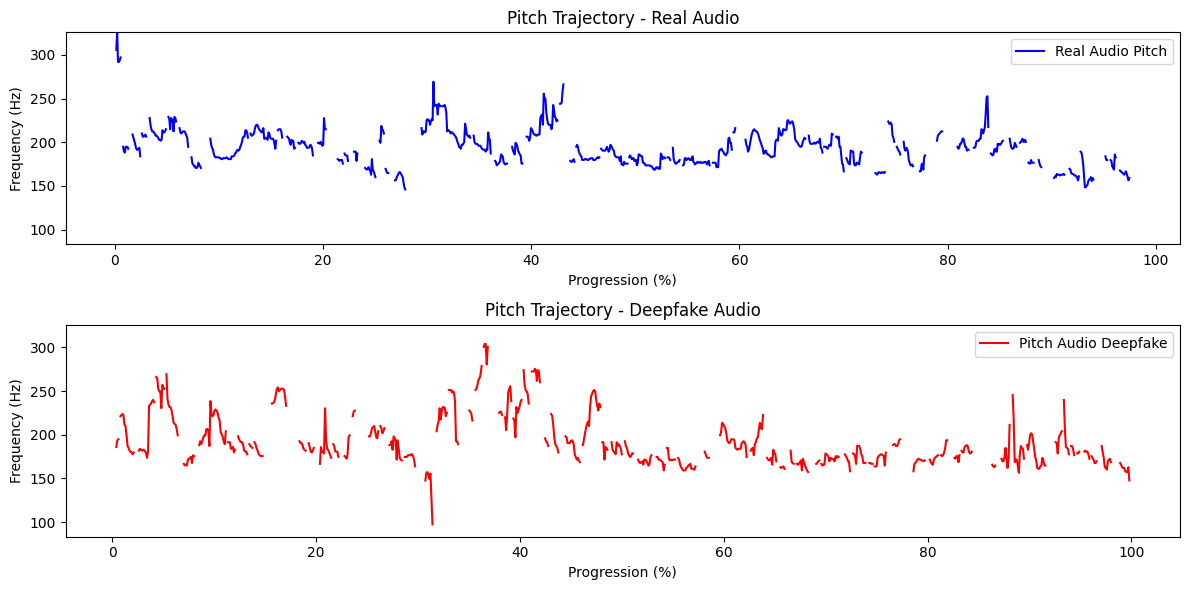

In [50]:
plot_pitch_comparison(wav1, wav2, sr=16000)

In [51]:
def plot_pitch_histogram(wav1, wav2, sr, normalize=True):
    """
    Visualizza un istogramma della distribuzione del pitch per entrambi gli audio,
    assicurandosi che abbiano la stessa durata o normalizzando le distribuzioni.
    """
    f0_1 = compute_pitch(wav1, sr)
    f0_2 = compute_pitch(wav2, sr)
    
    # Rimuove eventuali valori NaN
    f0_1_clean = f0_1[~np.isnan(f0_1)]
    f0_2_clean = f0_2[~np.isnan(f0_2)]
    
    # Uniformare la durata dei pitch estratti
    min_length = min(len(f0_1_clean), len(f0_2_clean))
    f0_1_clean = f0_1_clean[:min_length]
    f0_2_clean = f0_2_clean[:min_length]
    
    plt.figure(figsize=(12, 6))
    
    # Normalizzazione delle distribuzioni se richiesto
    if normalize:
        plt.hist(f0_1_clean, bins=30, alpha=0.7, density=True, label="Real Audio Pitch", color='blue')
        plt.hist(f0_2_clean, bins=30, alpha=0.7, density=True, label="Deepfake Audio Pitch", color='red')
        plt.ylabel("Probability Density")
    else:
        plt.hist(f0_1_clean, bins=30, alpha=0.7, label="Real Audio Pitch", color='blue')
        plt.hist(f0_2_clean, bins=30, alpha=0.7, label="Deepfake Audio Pitch", color='red')
        plt.ylabel("Frequency")
    
    plt.xlabel("Pitch (Hz)")
    plt.title("Pitch Distribution")
    plt.legend()
    plt.show()


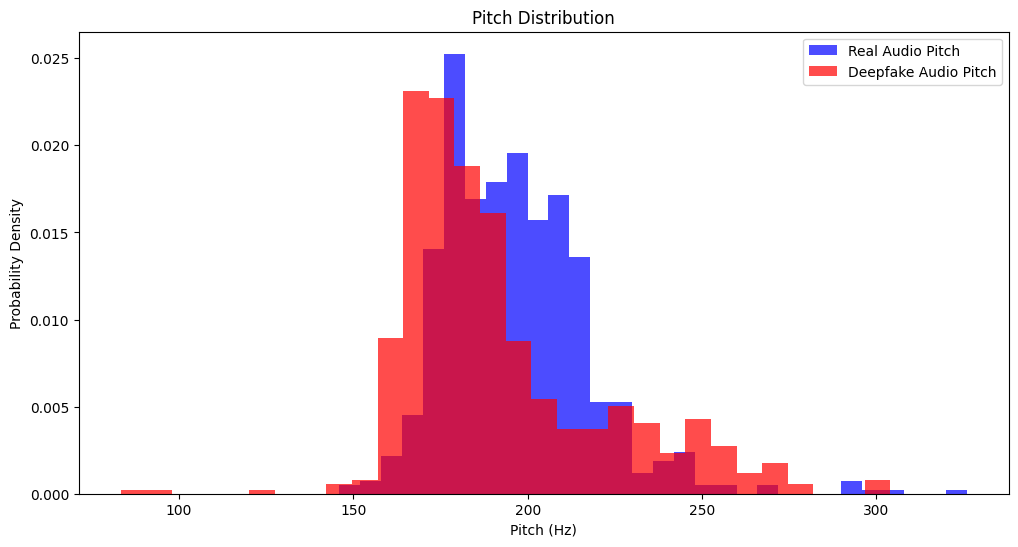

In [52]:
# Visualizza la distribuzione del Pitch con un istogramma
plot_pitch_histogram(wav1, wav2, sr=16000)

# Spectral Centroid Analysis
Indicates the "brightness" or "brilliance" of the sound, to check for any differences in timbre between the two recordings

In [53]:
def compute_spectral_centroid(y, sr, hop_length=512):
    """
    Calcola il centroide spettrale dell'audio.
    """
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=hop_length)
    return centroid[0]

def plot_spectral_centroid_comparison(wav1, wav2, sr, hop_length=512):
    """
    Visualizza il centroide spettrale per entrambi gli audio, normalizzando l'asse temporale
    e impostando la stessa scala sull'asse y per un confronto equo.
    """
    cent1 = compute_spectral_centroid(wav1, sr, hop_length=hop_length)
    cent2 = compute_spectral_centroid(wav2, sr, hop_length=hop_length)
    
    # Calcola i limiti globali (minimo e massimo) per impostare la stessa scala
    global_min = min(cent1.min(), cent2.min())
    global_max = max(cent1.max(), cent2.max())
    
    # Crea assi temporali normalizzati (0-100%)
    times1 = np.linspace(0, 100, len(cent1))
    times2 = np.linspace(0, 100, len(cent2))
    
    plt.figure(figsize=(12, 6))
    
    # Plot per l'audio reale
    plt.subplot(2, 1, 1)
    plt.plot(times1, cent1, color='blue', label="Spectral Centroid - Real Audio")
    plt.xlabel("Progression (%)")
    plt.ylabel("Frequency (Hz)")
    plt.title("Spectral Centroid - Real Audio")
    plt.ylim(global_min, global_max)
    plt.legend()
    
    # Plot per l'audio deepfake
    plt.subplot(2, 1, 2)
    plt.plot(times2, cent2, color='red', label="Spectral Centroid - Deepfake Audio")
    plt.xlabel("Progression (%)")
    plt.ylabel("Frequency (Hz)")
    plt.title("Spectral Centroid - Deepfake Audio")
    plt.ylim(global_min, global_max)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

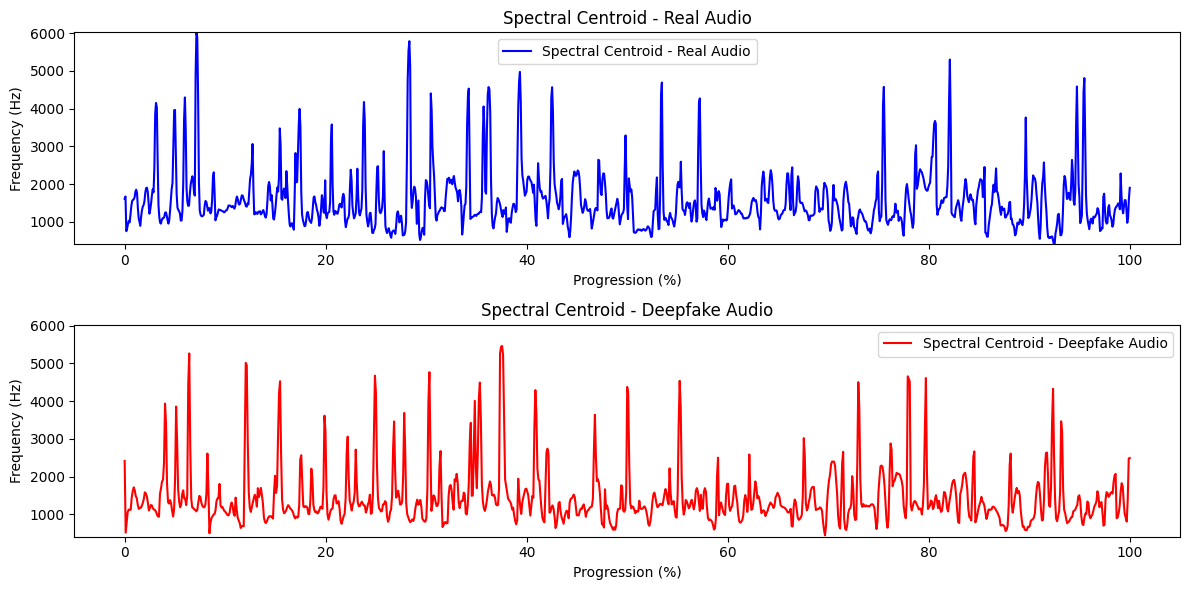

In [54]:
# Visualizza il confronto del Centroide Spettrale
plot_spectral_centroid_comparison(wav1, wav2, sr=16000)

# RMS (Root Mean Square)
Calculation of RMS energy to highlight dynamic variations (e.g. louder or quieter parts) over time, also displayed on a normalized axis.

In [55]:
def compute_rms_energy(y, frame_length=2048, hop_length=512):
    """
    Calcola l'energia RMS dell'audio.
    """
    rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
    return rms

def plot_rms_comparison(wav1, wav2, sr, hop_length=512, frame_length=2048):
    """
    Visualizza le curve dell'energia RMS per i due audio, normalizzando l'asse temporale
    e impostando una scala comune sull'asse y per un confronto equo.
    """
    rms1 = compute_rms_energy(wav1, frame_length=frame_length, hop_length=hop_length)
    rms2 = compute_rms_energy(wav2, frame_length=frame_length, hop_length=hop_length)
    
    # Calcola i limiti globali per l'asse y
    global_min = min(rms1.min(), rms2.min())
    global_max = max(rms1.max(), rms2.max())
    
    # Crea assi temporali normalizzati (0-100%)
    times1 = np.linspace(0, 100, len(rms1))
    times2 = np.linspace(0, 100, len(rms2))
    
    plt.figure(figsize=(12, 6))
    
    # Plot per l'audio reale
    plt.subplot(2, 1, 1)
    plt.plot(times1, rms1, color='blue', label="RMS Real Audio")
    plt.xlabel("Progression (%)")
    plt.ylabel("RMS Energy")
    plt.title("RMS Energy - Real Audio")
    plt.ylim(global_min, global_max)
    plt.legend()
    
    # Plot per l'audio deepfake
    plt.subplot(2, 1, 2)
    plt.plot(times2, rms2, color='red', label="RMS Deepfake Audio")
    plt.xlabel("Progression (%)")
    plt.ylabel("RMS Energy")
    plt.title("RMS Energy - Deepfake Audio")
    plt.ylim(global_min, global_max)
    plt.legend()
    
    plt.tight_layout()
    plt.show()


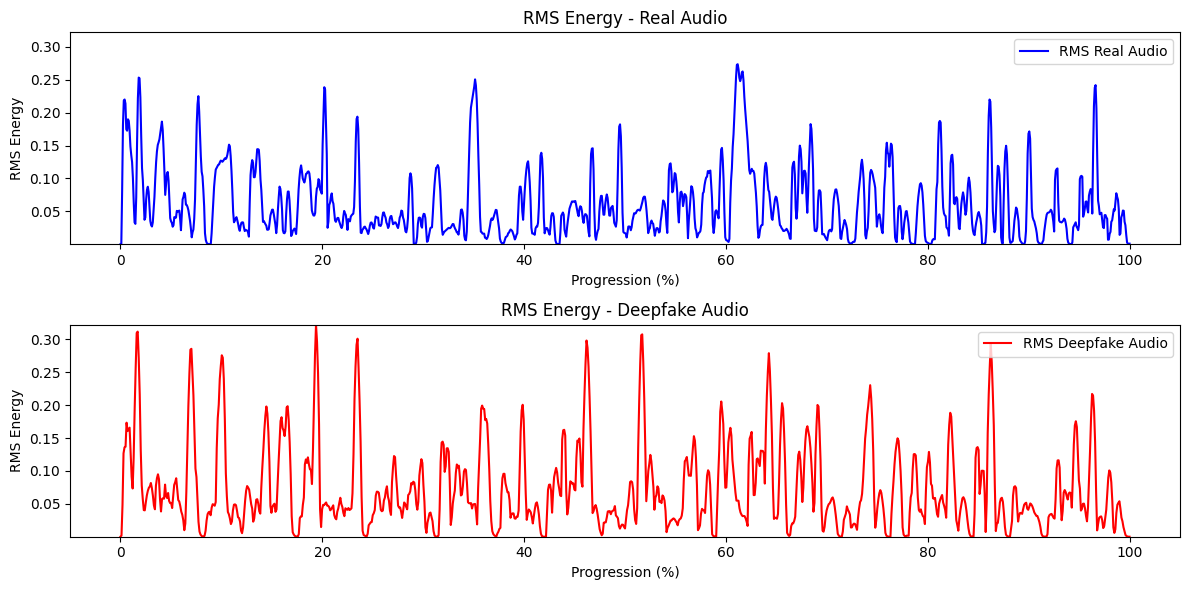

In [56]:
# Visualizza il confronto dell'energia RMS
plot_rms_comparison(wav1, wav2, sr=16000)